<h1><center>Изучения российского проката</center></h1>

## Введение



Алгоритм работы:
   1. Введение
   2. Разделим данные на обучающую, валидационную и тестовую выборки
   3. Исследуем качество разных моделей, меняя гиперпараметры
   4. Проверим качество моделей на тестовой выборке.
   5. Проверим модели на вменяемость
   6. Общий вывод

Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.
Известно:

-   сalls — количество звонков,
-   minutes — суммарная длительность звонков в минутах,
-   messages — количество sms-сообщений,
-   mb_used — израсходованный интернет-трафик в Мб,
-  is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Изучим рынок российского кинопроката и выявим текущие тренды. Уделим внимание фильмам, которые
получили государственную поддержку. Попробуем ответить на вопрос, насколько такие фильмы интересны зрителю. Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.

Алгоритм работы:
1. Ознакомление с целью исследовательской работы
2. Обзор данных
3. Предобработка данных
4. Проведем исследовательский анализ данных:
    - посчитаем, сколько фильмов выходило в прокат каждый год
    - выясним, в каком году сумма сборов была минимальной\максимальной
    - посчитаем среднюю и медианную сумму сборов для каждого года
    - определим, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма
      в прокате в период с 2015 по 2019 год
    - фильмы с каким возрастным ограничением собрали больше всего денег в прокате  
    - выясним, меняется ли ситуация в зависимости от года
5. Исследуем фильмы, которые получили государственную поддержку. Посчитаем, сколько выделяют средств на поддержку кино. Проверим, хорошо ли окупаются такие фильмы, какой у них рейтинг.  
6. Общий вывод

## Обзор данных

Посмотрим имеющиеся датасеты

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import urllib.request

from os import path
from pathlib import Path
warnings.simplefilter('ignore')


In [20]:
YANDEX_DATASETS_PATH = 'https://code.s3.yandex.net/datasets/'
dataset_folder = 'datasets'
dataset_names = ['mkrf_movies.csv', 'mkrf_shows.csv']

for dataset_name in dataset_names:
    #download dataset if not existed
    if not path.exists(dataset_folder + '/' + dataset_name):
        #create dir if not existed
        Path(dataset_folder).mkdir(parents=True, exist_ok=True)

        #download dataset
        urllib.request.urlretrieve(YANDEX_DATASETS_PATH + dataset_name,
                                dataset_folder + '/' + dataset_name)

# Read file
data_movies = pd.read_csv('datasets/mkrf_movies.csv')
data_movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

In [21]:
data_movies.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама"
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный"
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"


In [22]:
data_shows = pd.read_csv('datasets/mkrf_shows.csv')
data_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


In [23]:
data_shows.head()

,puNumber,box_office
0,111000113,2.450000e+03
1,111000115,6.104000e+04
2,111000116,1.530300e+08
3,111000117,1.226096e+07
4,111000118,1.636841e+08


Согласно документации:
-    title — название фильма;
-    puNumber — номер прокатного удостоверения;
-    show_start_date — дата премьеры фильма;
-    type — тип фильма;
-    film_studio — студия-производитель;
-    production_country — страна-производитель;
-    director — режиссёр;
-    producer — продюсер;
-    age_restriction — возрастная категория;
-    refundable_support — объём возвратных средств государственной поддержки;
-    nonrefundable_support — объём невозвратных средств государственной поддержки;
-    financing_source — источник государственного финансирования;
-    budget — общий бюджет фильма;
-    ratings — рейтинг фильма на КиноПоиске;
-    genres — жанр фильма.
-    box_office — сборы в рублях.

Вывод: в первом датасете имееются пропуски. Обе таблицы имеют общий столбец puNumber, по которому их можно объеденить.

## Предобработка данных

Объеденим таблицы, для этого преобразуем тип столбца puNumber в числовой

In [24]:
data_movies['puNumber'] = pd.to_numeric(data_movies['puNumber'], errors='coerce')
data_movies['puNumber'].isna().sum()

1

In [25]:
data_movies[data_movies['puNumber'].isnull()].head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
1797,Курбан-роман. (История с жертвой),NaN,2014-05-15T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


Одна строка не cконвертировалась, удалим ее. Поменяем тип столбца на целочисленный, чтобы правильно объеденить таблицы

In [26]:
data_movies = data_movies.dropna(subset=['puNumber']).reset_index(drop=True)
data_movies['puNumber'] = data_movies['puNumber'].astype(int)
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7485 entries, 0 to 7484
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7485 non-null   object 
 1   puNumber               7485 non-null   int32  
 2   show_start_date        7485 non-null   object 
 3   type                   7485 non-null   object 
 4   film_studio            7467 non-null   object 
 5   production_country     7483 non-null   object 
 6   director               7476 non-null   object 
 7   producer               6917 non-null   object 
 8   age_restriction        7485 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

Объеденим таблицы:

In [27]:
data = data_movies.merge(data_shows, on='puNumber', how='left')
data.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


Переведем тип столбца даты премьеры фильма в соответствующий формат

In [28]:
data['show_start_date'] = pd.to_datetime(data['show_start_date'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
data.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27 12:00:00,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


Рассмотрим категориальные значения, для нашего исследования нас интересуют:
- ratings (рейтинг)
- type (тип фильма)
- director (режиссер)
- genres (жанр)
- age_restriction (возрастные ограничения)

Рассмотрим столбец рейтинга

In [29]:
data['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4', '3.1',
       '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%', '90%',
       '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2', '1.7',
       '9.0', '98%', '8.9', '9.1'], dtype=object)

In [30]:
data[data['ratings'].isnull()].head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
43,Мемуары гейши (по роману Артура Голдена),121000606,2012-12-14 12:00:00,Художественный,"Коламбия Пикчерз Корпорейшн, ДримУоркс ЭсКейДж...",США,Роб Маршалл,"Стивен Спилберг, Люси Фишер, Дуглас Уик, Джон ...",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,Жди меня,111013615,2015-08-25 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,"А.Столпер, Б.Иванов",NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,Дом из песка и тумана (по книге Андре Дюбуи III),221037813,2013-10-25 12:00:00,Художественный,Кобальт Пикчерз,США,Вадим Перельман,Майкл Лондон,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,Жемчужная девушка,224011014,2014-08-28 12:00:00,Художественный,"Чешское телевидение,Студия ""Три брата"" агентск...",Чехия,Владимир Дрга,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,Полустанок,111026714,2014-12-24 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Б.Барнет,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data['ratings'].isna().sum()

966

In [32]:
data[data['ratings'].isnull()].head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
43,Мемуары гейши (по роману Артура Голдена),121000606,2012-12-14 12:00:00,Художественный,"Коламбия Пикчерз Корпорейшн, ДримУоркс ЭсКейДж...",США,Роб Маршалл,"Стивен Спилберг, Люси Фишер, Дуглас Уик, Джон ...",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,Жди меня,111013615,2015-08-25 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,"А.Столпер, Б.Иванов",NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,Дом из песка и тумана (по книге Андре Дюбуи III),221037813,2013-10-25 12:00:00,Художественный,Кобальт Пикчерз,США,Вадим Перельман,Майкл Лондон,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,Жемчужная девушка,224011014,2014-08-28 12:00:00,Художественный,"Чешское телевидение,Студия ""Три брата"" агентск...",Чехия,Владимир Дрга,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,Полустанок,111026714,2014-12-24 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Б.Барнет,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Нулевые значения составляют значимую часть нашей выборки. Они несут полезную информацию для нашего исследования - не будем их удалять. А значения с процентами переведем в десятичные дроби

In [33]:
def percent_to_decimal(x):
    if ( (type(x) is str) and ('%' in x )):
        x = x.strip('%')
        return x[:-1] + '.' + x[-1]
    else:
        return x

In [34]:
data['ratings'] = data['ratings'].apply(percent_to_decimal)
data['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '9.9', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '2.8', '3.7', '1.4', '3.1',
       '9.7', '3.5', '3.2', '1.5', '2.1', '2.5', '9.2', '3.4', '1.1',
       '3.6', '9.1', '9.4', '9.0', '1.9', '1.0', '8.9', '1.3', '1.8',
       '1.2', '1.7', '9.8'], dtype=object)

Переведем столбец рейтинга в числовой для дальнейшего исследования

In [35]:
data['ratings'] = pd.to_numeric(data['ratings'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7484
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7485 non-null   object        
 1   puNumber               7485 non-null   int32         
 2   show_start_date        7485 non-null   datetime64[ns]
 3   type                   7485 non-null   object        
 4   film_studio            7467 non-null   object        
 5   production_country     7483 non-null   object        
 6   director               7476 non-null   object        
 7   producer               6917 non-null   object        
 8   age_restriction        7485 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

Рассмотрим столбец типа фильма:

In [36]:
data['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', ' Художественный', ' Анимационный',
       'Музыкально-развлекательный'], dtype=object)

Удалим дубликаты

In [37]:
data['type'] = data['type'].replace(' Художественный', 'Художественный')
data['type'] = data['type'].replace(' Анимационный', 'Анимационный')
data['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', 'Музыкально-развлекательный'], dtype=object)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7484
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7485 non-null   object        
 1   puNumber               7485 non-null   int32         
 2   show_start_date        7485 non-null   datetime64[ns]
 3   type                   7485 non-null   object        
 4   film_studio            7467 non-null   object        
 5   production_country     7483 non-null   object        
 6   director               7476 non-null   object        
 7   producer               6917 non-null   object        
 8   age_restriction        7485 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

Рассмотрим столбец возрастного ограничения:

In [39]:
data['age_restriction'].unique()

array(['«18+» - запрещено для детей', '«6+» - для детей старше 6 лет',
       '«12+» - для детей старше 12 лет',
       '«16+» - для детей старше 16 лет',
       '«0+» - для любой зрительской аудитории'], dtype=object)

Рассмотрим столбец жанра:

In [40]:
data['genres'].unique()

array(['боевик,драма,мелодрама', 'драма,военный',
       'фантастика,боевик,триллер', 'драма', 'мелодрама,комедия',
       'мюзикл,мелодрама,комедия', 'комедия,криминал',
       'боевик,триллер,детектив', 'боевик,драма,приключения',
       'драма,спорт', 'триллер,драма,мелодрама', 'комедия,мелодрама',
       'драма,мелодрама,комедия', 'драма,мелодрама', 'драма,история',
       'драма,мелодрама,семейный', 'комедия,мелодрама,криминал',
       'комедия', 'боевик,драма,криминал', 'драма,комедия',
       'ужасы,фантастика,комедия', 'мультфильм,короткометражка,мелодрама',
       'драма,криминал', 'мультфильм,фантастика,фэнтези',
       'триллер,драма,криминал', 'драма,мелодрама,биография',
       'драма,комедия,военный', 'фантастика,драма,детектив',
       'мюзикл,семейный', nan, 'военный,приключения,драма',
       'документальный,драма', 'драма,биография,история',
       'боевик,триллер,драма', 'фэнтези,боевик',
       'боевик,комедия,криминал', 'мюзикл,комедия,детский',
       'комедия,мел

Столбец переведем в строковый тип для дальнейшей обработки

In [41]:
data['genres'] = data['genres'].astype(str)

Рассмотрим столбец имени режиссера:

In [42]:
data['director'].unique()

array(['Кевин Костнер', 'Е.Матвеев', 'Тимур Бекмамбетов', ...,
       'Ник Пауэлл', 'А.Беляев', 'И.Трусов'], dtype=object)

Переведем столбец в строковый тип для дальнейшей обработки

In [43]:
data['director'] = data['director'].astype(str)

Рассмотрим количественные переменные. Для нашего исследования нас интересуют:
- budget (бюджет)
- refundable_support (объём возвратных средств)
- nonrefundable_support (объём невозвратных средств)
- box_office (сборы)

Рассмотрим колонку бюджета

In [44]:
data['budget'].describe()

count    3.320000e+02
mean     1.272297e+08
std      1.885883e+08
min      0.000000e+00
25%      4.200000e+07
50%      6.864992e+07
75%      1.419853e+08
max      2.305074e+09
Name: budget, dtype: float64

In [45]:
data[data['budget'] == 0]['budget'].count()

17

Имеются небольшое кол-во пропусков, удалим их

In [46]:
data = data[data['budget'] != 0].reset_index(drop=True)
data[data['budget'] == 0]['budget'].count()

0

In [47]:
data[data['budget'].isna()]['budget'].count()

0

Рассмотрим колонку объёма возвратных средств

In [48]:
data['refundable_support'].describe()

count    3.150000e+02
mean     1.160317e+07
std      2.515144e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+07
max      1.800000e+08
Name: refundable_support, dtype: float64

Рассмотрим колонку объёма невозвратных средств

In [49]:
data['nonrefundable_support'].describe()

count    3.150000e+02
mean     4.810704e+07
std      5.988614e+07
min      0.000000e+00
25%      2.500000e+07
50%      3.000000e+07
75%      4.000000e+07
max      4.000000e+08
Name: nonrefundable_support, dtype: float64

Колонка budget включает в себя общий бюджет, а следовательно сумму колонок refundable_support и nonrefundable_support. Проверим, везде ли выполняется это условие

In [50]:
data[data['budget'] < (data['refundable_support'] + data['nonrefundable_support'])]['budget'].count()

0

Рассмотрим колонку сборов фильма

In [51]:
data['box_office'].describe()

count    3.141000e+03
mean     7.600967e+07
std      2.402503e+08
min      0.000000e+00
25%      8.395000e+04
50%      2.284862e+06
75%      2.344112e+07
max      3.073569e+09
Name: box_office, dtype: float64

In [52]:
data[data['box_office'] == 0]['box_office'].count()

24

Удалим пропуски

In [53]:
data = data[data['box_office'] != 0].reset_index(drop=True)
data[data['box_office'] == 0]['box_office'].count()

0

In [54]:
data['box_office'].describe()

count    3.117000e+03
mean     7.659493e+07
std      2.410807e+08
min      4.000000e+01
25%      9.684600e+04
50%      2.351960e+06
75%      2.376625e+07
max      3.073569e+09
Name: box_office, dtype: float64

Имеются очень низкие значения(min 4.000000e+01), но с другой стороны, фильм мог полностью провалиться

Проверим дупликаты

In [55]:
data.duplicated().sum()

0

Дупликатов нет. Создадим дополнительные колонки для нашего исследования

Создадим столбец с годом премьеры

In [56]:
data['start_year'] = pd.DatetimeIndex(data['show_start_date']).year

Создадим столбцы с главным режиссером и основным жанром фильма

In [57]:
data['director_major'] = data.apply(lambda x: x['director'].split(',')[0], axis=1)

In [58]:
data['genre_major'] = data.apply(lambda x: x['genres'].split(',')[0], axis=1)

Создадим колонку, где посчитаем, какую долю от общего бюджета фильма составляет государственная поддержка

In [59]:
data['budget_gov'] = (data['refundable_support'] + data['nonrefundable_support']) / data['budget']

Проверим

In [60]:
data.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,start_year,director_major,genre_major,budget_gov
0,Открытый простор,221048915,2015-11-27 12:00:00,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN,2015,Кевин Костнер,боевик,NaN
1,Особо важное задание,111013716,2016-09-13 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN,2016,Е.Матвеев,драма,NaN
2,Особо опасен,221038416,2016-10-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,2016,Тимур Бекмамбетов,фантастика,NaN
3,Особо опасен,221026916,2016-06-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,2016,Тимур Бекмамбетов,фантастика,NaN
4,Особо опасен,221030815,2015-07-29 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,2015,Тимур Бекмамбетов,фантастика,NaN


Вывод: мы соединили оба датасета и увидели, что информация о прокатных сборах имеется только у небольшой части фильмов. Мы удалили нулевые значения для столбцов бюджета и общих сборов, потому что они будут иметь место в дальнейшем анализе. 

## Исследовательский анализ данных проката


Посмотрим, сколько фильмов выходило в прокат каждый год. Посчитаем, какую долю составляют фильмы с информацией о прокате к общему кол-ву.

<AxesSubplot:title={'center':'Количество фильмов по годам'}, xlabel='start_year'>

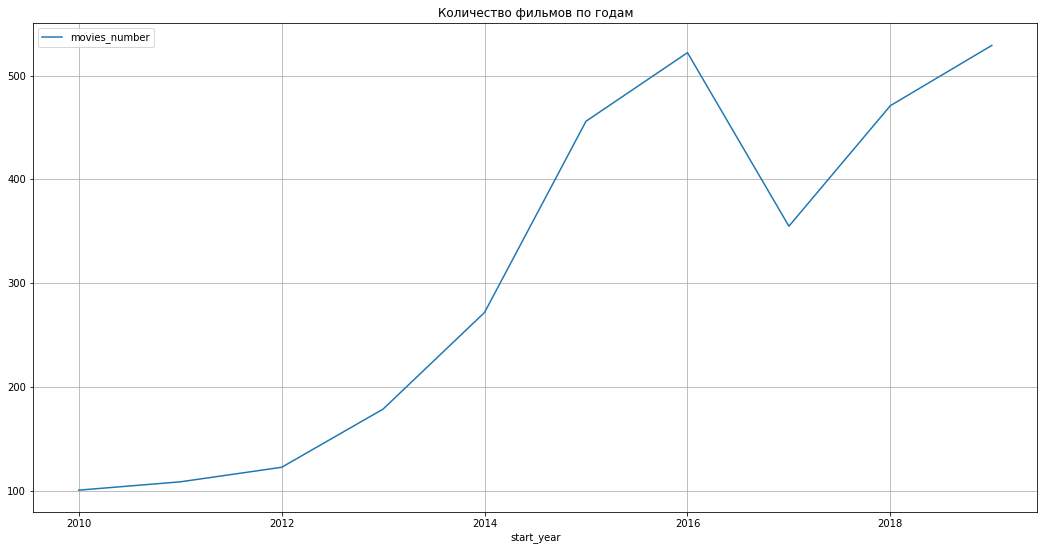

In [61]:
data_year = data[~(data['box_office'].isnull())].pivot_table(values='title', index='start_year', aggfunc='count')
data_year.columns = ['movies_number']
data_year.plot(grid=True, figsize=(18, 9), title='Количество фильмов по годам')

In [62]:
data[~(data['box_office'].isnull())]['puNumber'].count()/data['puNumber'].count()

0.418726491133799

Вывод: количество фильмов в прокате росло до 2016 года, потом спад в 2017 и снова плавный рост до 2019. Правда в нашей базе у нас информация о прокате только 41% всех фильмов.

Исследуем, как менялась динамика проката по годам. Посмотрим, в каком году сумма сборов была минимальной\максимальной.

<AxesSubplot:title={'center':'Общие сборы по годам'}, xlabel='start_year'>

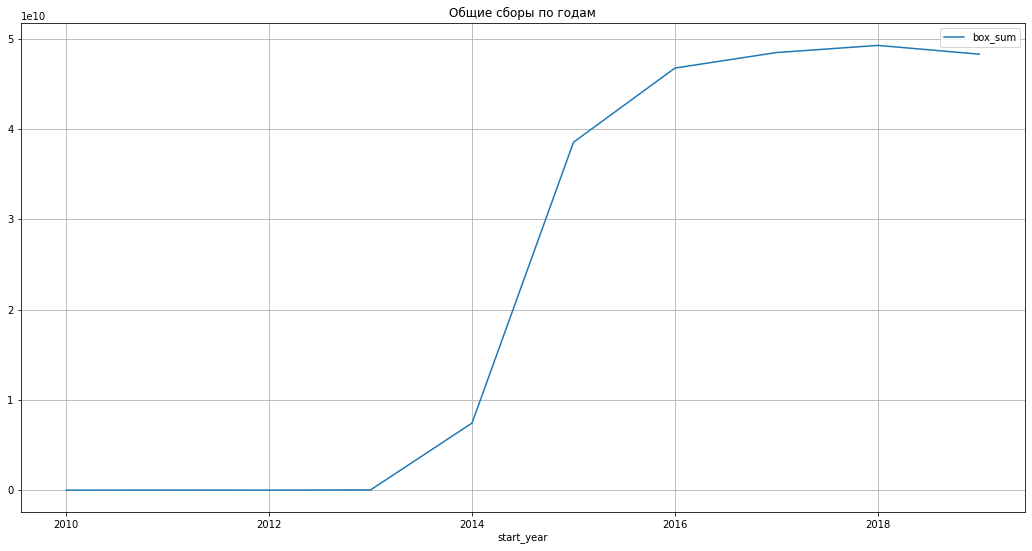

In [63]:
data_box = data[~(data['box_office'].isnull())].pivot_table(values='box_office', index='start_year', aggfunc=['sum'])
data_box.columns = ['box_sum']
data_box.plot(grid=True, figsize=(18, 9), title='Общие сборы по годам')

Вывод: минимальные сборы были в 2014 году, максимальные в 2018. Резкий рост до 2016 года. Далее стагнация до 2019. Такая динамика до 2015 года скорее всего вызвана недостатком данных в нашей базе.

Посмотрим среднюю и медиану для сборов по каждому из годов

<AxesSubplot:title={'center':'Динамика проката по годам'}, xlabel='start_year'>

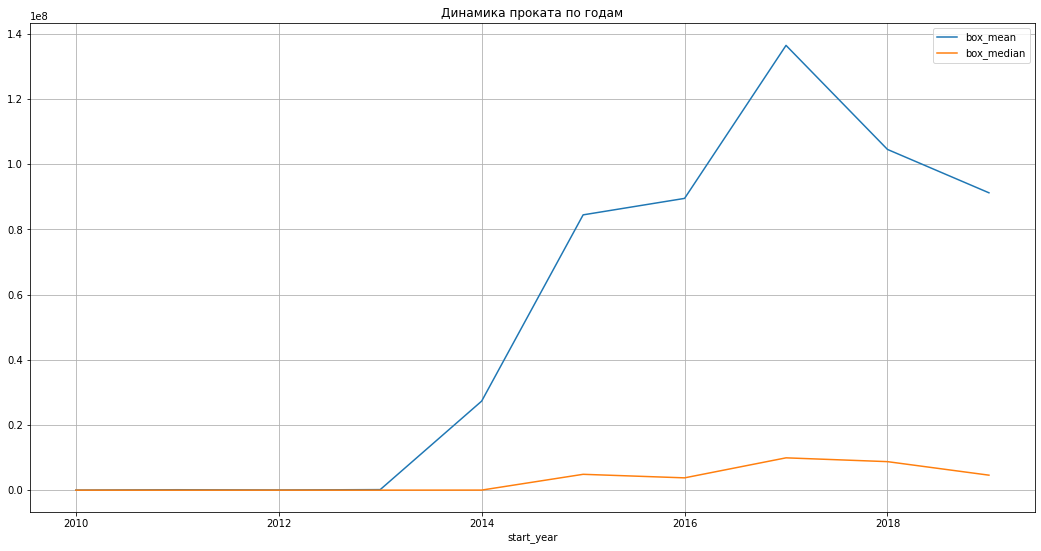

In [64]:
data_box = data[~(data['box_office'].isnull())].pivot_table(values='box_office', index='start_year', aggfunc=['mean', 'median'])
data_box.columns = ['box_mean', 'box_median']
data_box.plot(grid=True, figsize=(18, 9), title='Динамика проката по годам')

Посмотрим распределение сборов по годам

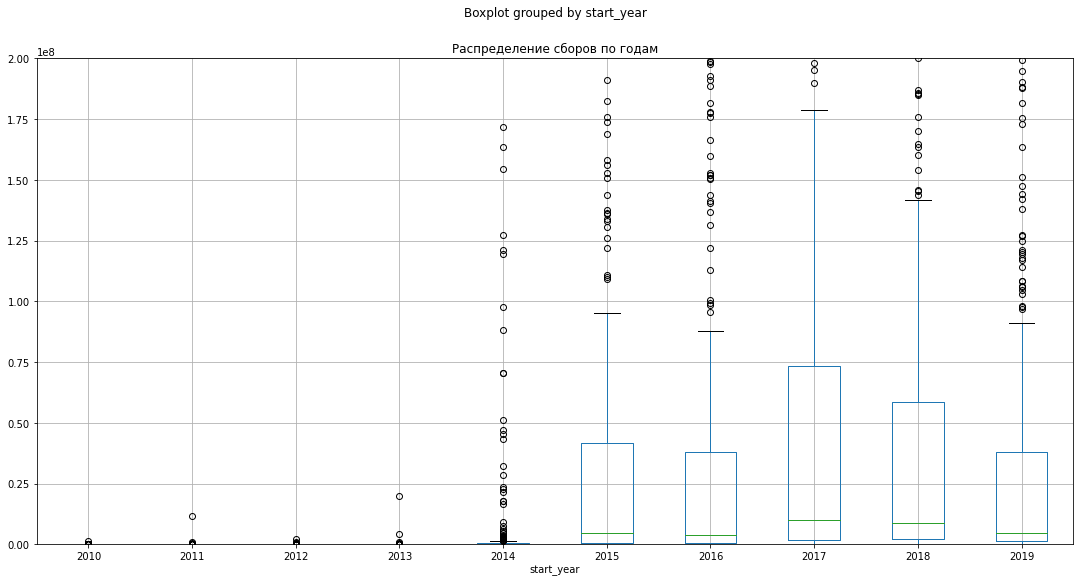

In [65]:
data_box_group = data[~(data['box_office'].isnull())].boxplot(figsize=(18,9), by='start_year', column='box_office')
plt.ylim(0, 200000000)
plt.title("Распределение сборов по годам")
plt.show()

In [66]:
data[~(data['box_office'].isnull())]['box_office'].describe()

count    3.117000e+03
mean     7.659493e+07
std      2.410807e+08
min      4.000000e+01
25%      9.684600e+04
50%      2.351960e+06
75%      2.376625e+07
max      3.073569e+09
Name: box_office, dtype: float64

Вывод: пик средних и медианых значений сборов проката приходится на 2017 год. Среднее значение намного выше медианного, за счет фильмов-блокбастеров собравших кассу, намного превосходящую средние сборы.

Определим, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год. Посмотрим, фильмы с каким возрастным ограничением собрали больше всего денег в прокате. Определим, меняется ли картина в зависимости от года.

In [67]:
data_2015 = data[ (data['start_year'] >= 2015) & ~(data['box_office'].isnull())]

In [68]:
data_age = data_2015.pivot_table(values='box_office', index='start_year', columns=['age_restriction'])

<AxesSubplot:title={'center':'Сборы по возрастным ограничениям'}, xlabel='start_year'>

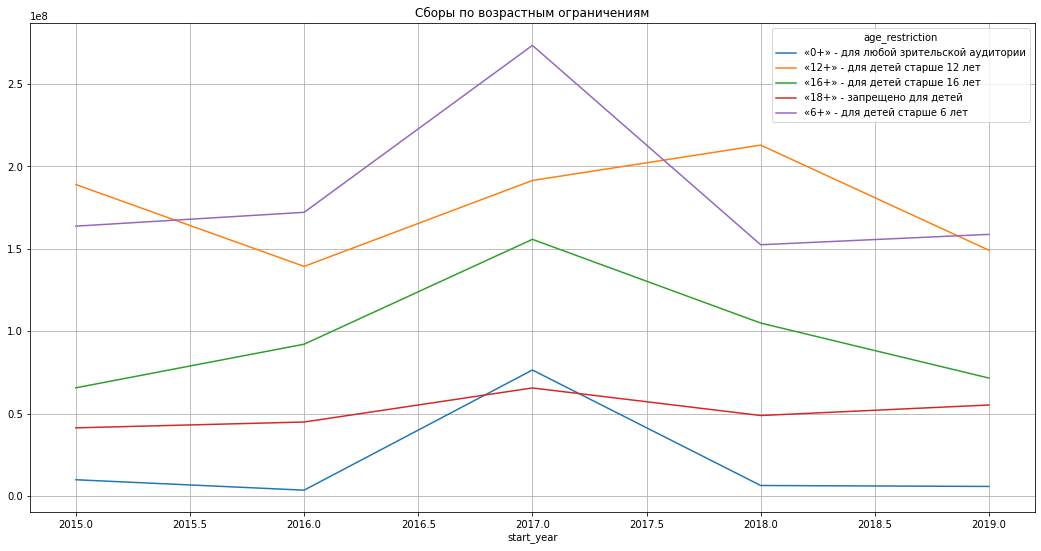

In [69]:
data_age.plot(grid=True, figsize=(18, 9), title='Сборы по возрастным ограничениям')

Вывод: в среднем фильмы категории "6+" и "12+" собирают больше остальных. Меньше собирают фильмы "16+", потом "18+" и "0+". Итого по среднем сборам: "6+" > "12+" > "16+" > "18+" > "0+". Динамика практически не меняется по годам.

In [70]:
data_age_sum = data_2015.pivot_table(values='box_office', index=['age_restriction'], aggfunc='sum')

In [71]:
data_age_sum.sort_values(by='box_office', ascending=False)

,box_office
age_restriction,
«16+» - для детей старше 16 лет,7.510227e+10
«12+» - для детей старше 12 лет,5.936919e+10
«6+» - для детей старше 6 лет,5.522019e+10
«18+» - запрещено для детей,4.075766e+10
«0+» - для любой зрительской аудитории,8.090774e+08


Вывод: за весь период наибольшие суммарные общие сборы у категории "16+", наименьшие у "0+"

<AxesSubplot:title={'center':'Сборы по возрастным ограничениям'}, xlabel='start_year'>

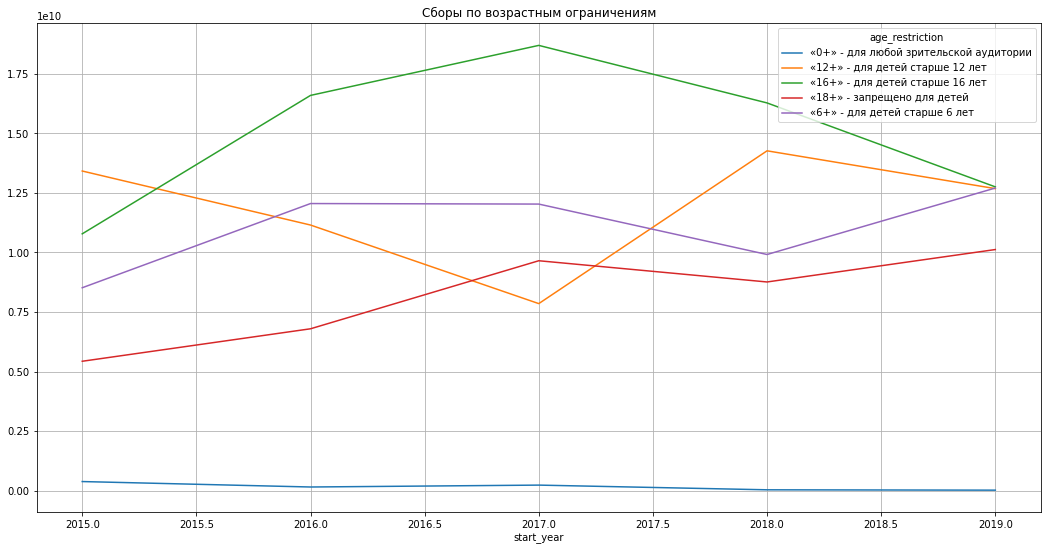

In [72]:
data_age_sum_year = data_2015.pivot_table(values='box_office', index='start_year', columns=['age_restriction'], aggfunc='sum')
data_age_sum_year.plot(grid=True, figsize=(18, 9), title='Сборы по возрастным ограничениям')

В 2017 году категория "12+" показала свой наихудший рельзультат. Возможно, это связано с падением кол-ва фильмов в этой категории. Посмотрим количество фильмов по категориям за каждый год и сравним их с общими сборами

<AxesSubplot:title={'center':'Количество фильмов по возрастным ограничениям'}, xlabel='start_year'>

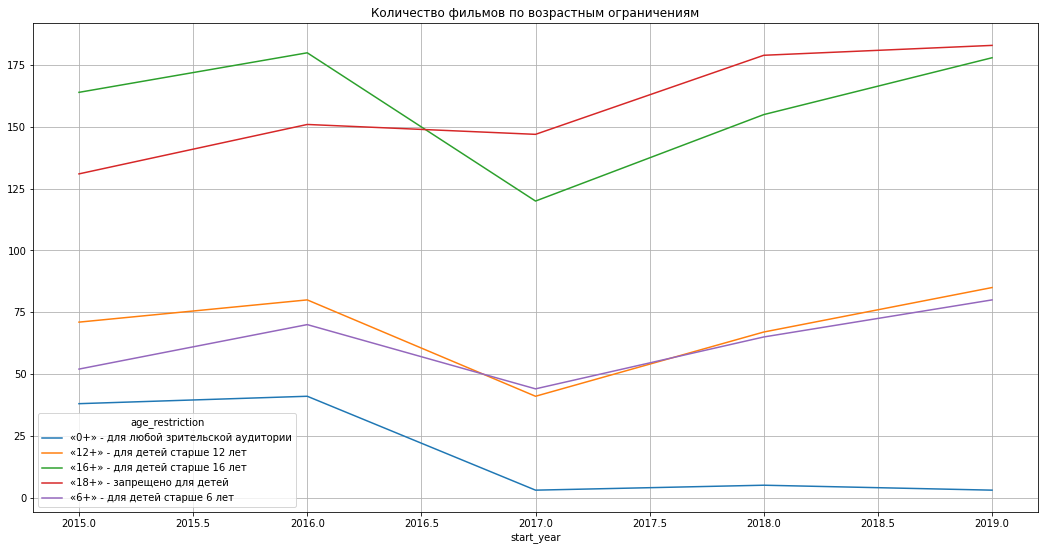

In [73]:
data_age_count_year = data_2015.pivot_table(values='box_office', index='start_year', columns=['age_restriction'], aggfunc='count')
data_age_count_year.plot(grid=True, figsize=(18, 9), title='Количество фильмов по возрастным ограничениям')

Вывод: на протяжении периода суммарные наибольшие сборы по годам, за исключением 2015, у категории "16+". Наименьшие у "0+" за все годы.

<div class="alert alert-info">Попробовал. Но данные оказались противоречивыми

Общий вывод: общее кол-во фильмов и совокупные сборы росли до 2016 года. в 2017 году произошел спад общего кол-ва представленных фильмов, но все вернулось на прежние места уже в 2018. Общие сборы же практически не менялись с 2016 года. И даже показали небольшой рост в 2017 из-за высоких сборов показанных за тот год фильмов. Самую большую прокатную кассу показали фильмы категории "16+", самые низкие сборы у категории "0+". В 2017 году "12+" показала самые низкие сборы. Возможно, это связано с падением кол-ва снятых фильмов в этой категории. По этому показателю она уступила всем категориям за исключением "0". С другой стороны кол-во снятых фильмов не всегда отражает общие сборы, что можно наблюдать по динамике категории "16+", которая в 2017 году, потеряв в объеме снятых фильмов, показала рекордные сборы за весь период.

## Исследование фильмов, которые получили государственную поддержку

Посмотрим, сколько выделяют средств на поддержку кино

In [74]:
data_gov = data[~(data['budget_gov'].isnull())]
data_gov['budget_gov_sup'] = data_gov['budget'] * data_gov['budget_gov']
data_gov['budget_gov_sup'].describe()

count    3.150000e+02
mean     5.971022e+07
std      7.308521e+07
min      3.000000e+06
25%      2.525000e+07
50%      3.500000e+07
75%      6.000000e+07
max      5.000000e+08
Name: budget_gov_sup, dtype: float64

<AxesSubplot:title={'center':'Гос финансирование кино по годам'}, xlabel='start_year'>

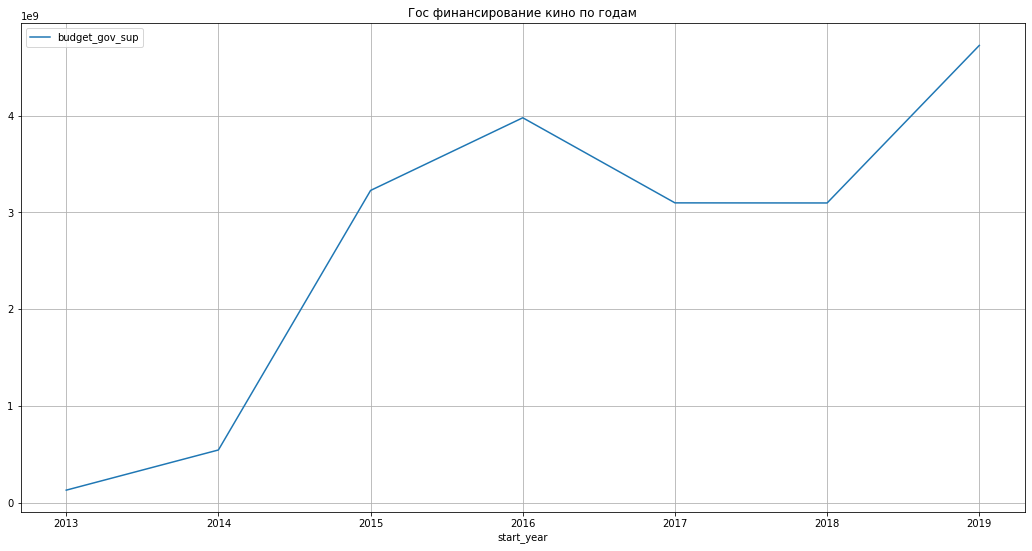

In [75]:
data_gov_sum = data_gov.pivot_table(values='budget_gov_sup', index='start_year', aggfunc='sum')
data_gov_sum.plot(grid=True, figsize=(18, 9), title='Гос финансирование кино по годам')

Вывод: государственное финансирование фильмов с годами увеличивается.

 Посчитаем, какую часть от общего проката составляли фильмы с гос поддержкой за каждый год. Данные о бюджете есть только для фильмов с гос поддержкой, отсюда и посчитаем их численность.

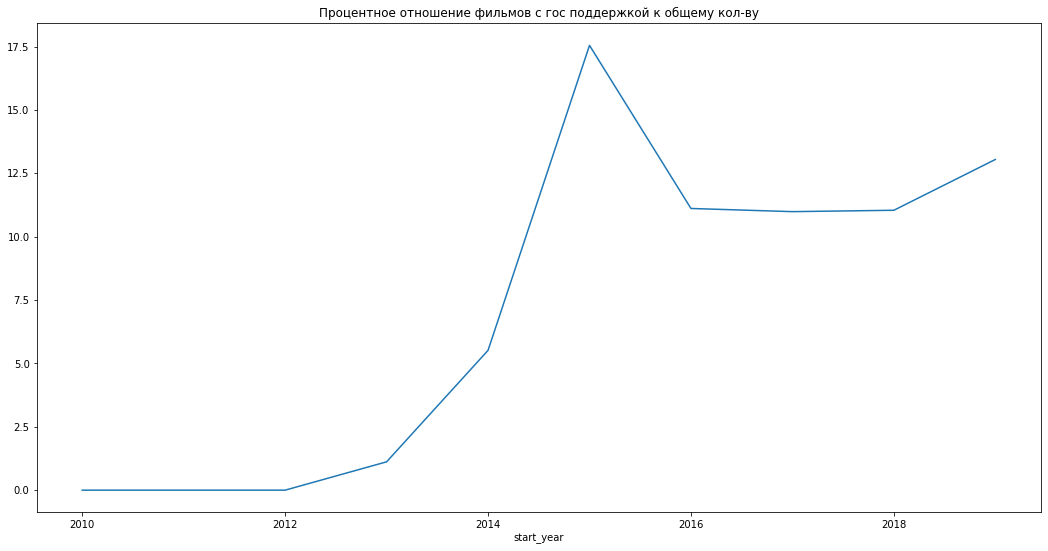

In [76]:
data_gov_count = data.groupby(by='start_year')['budget', 'box_office'].count()
data_gov_count.columns = ['budget', 'box_office']
data_gov_count['gos/overall'] = data_gov_count['budget'] / data_gov_count['box_office'] * 100
data_gov_count['gos/overall'].plot(figsize=(18, 9))
plt.title('Процентное отношение фильмов с гос поддержкой к общему кол-ву')
plt.show()

Вывод: Средний процент поддерживаемых фильмов около 12%

Посмотрим, какой рейтинг у этих фильмов и сравним его с общим рейтингов по всем фильмам

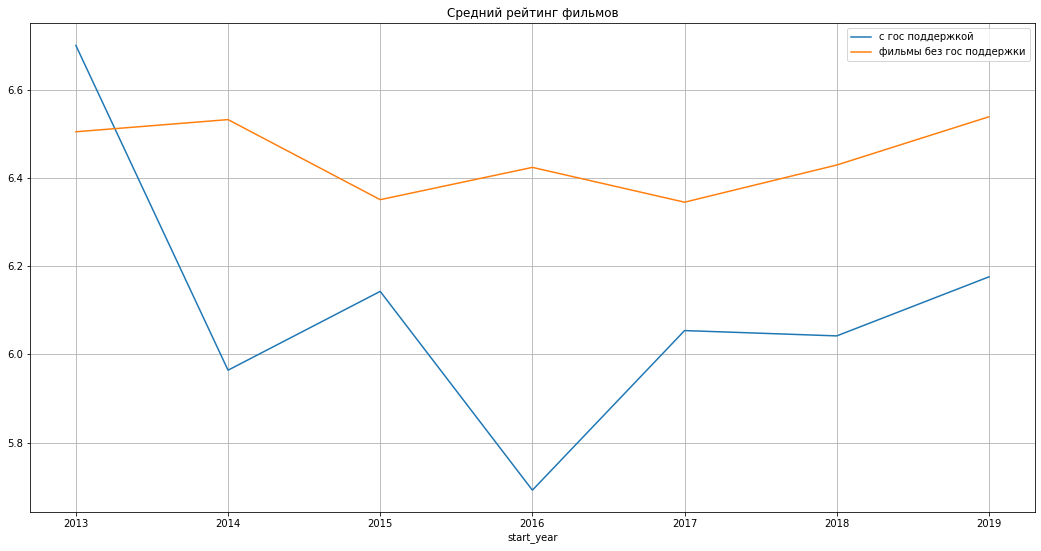

In [77]:
data_gov_ratings = data_gov.pivot_table(values='ratings', index='start_year', aggfunc='mean')
data_ratings = data[ ( data['start_year'] >= 2013 )
                        & (data['budget_gov'].isnull())].pivot_table(values='ratings',
                                                                     index='start_year',
                                                                     aggfunc='mean')
pivot_data = pd.concat([ data_gov_ratings, data_ratings], axis=1)
pivot_data.columns = ['с гос поддержкой', 'фильмы без гос поддержки']
pivot_data.plot(grid=True, figsize=(18, 9))
plt.title('Средний рейтинг фильмов')
plt.show()

Вывод: средний рейтинг фильмов с гос поддержкой ниже среднего по фильмам без

Посмотрим среднюю окупаемость этих фильмов

<div class="alert alert-info"> Вот здесь как-то можно по оси y от "1.0" горизонтальную цветную линию провести, чтобы отделить участок окупаемости/неокупаемости?

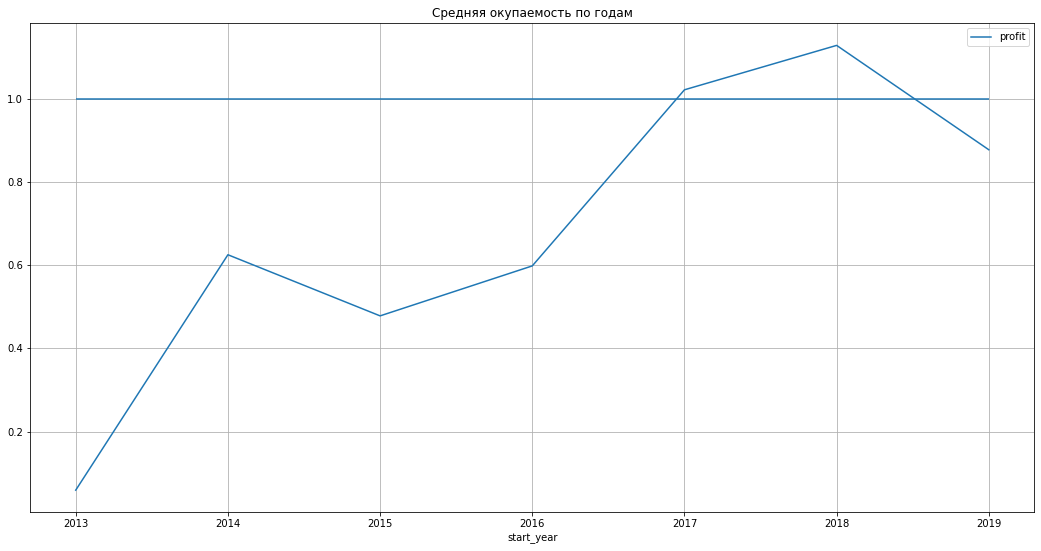

In [78]:
data_gov['profit'] = data_gov['box_office'] / data_gov['budget']
data_gov_profit = data_gov.pivot_table(values='profit', index='start_year', aggfunc='mean')
data_gov_profit.plot(grid=True, figsize=(18, 9), title='Средняя окупаемость по годам')
plt.hlines(1,2013, 2019)
plt.show()

Вывод: только в 2017 и 2018 году фильмы в среднем окупили потраченные средства

Посмотрим средние сборы этих фильмов и сравним их с фильмами без поддержки

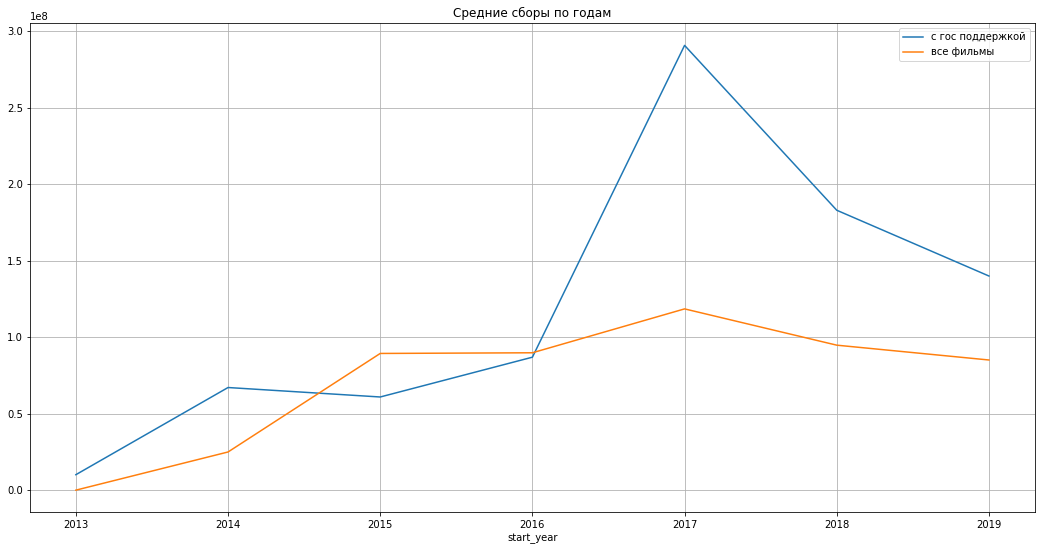

In [79]:
data_gov_box = data_gov.pivot_table(values='box_office', index='start_year', aggfunc='mean')
data_box = data[(data['start_year'] >= 2013) &
                      (data['budget_gov'].isnull())].pivot_table(values='box_office',
                                                                  index='start_year',
                                                                  aggfunc='mean')
pivot_data = pd.concat([ data_gov_box, data_box], axis=1)
pivot_data.columns = ['с гос поддержкой', 'все фильмы']
pivot_data.plot(grid=True, figsize=(18, 9))
plt.title('Средние сборы по годам')
plt.show()

Вывод: средние сборы фильмов с гос поддержкой выше средних по фильмам без поддержки

Теперь сравним суммарные сборы

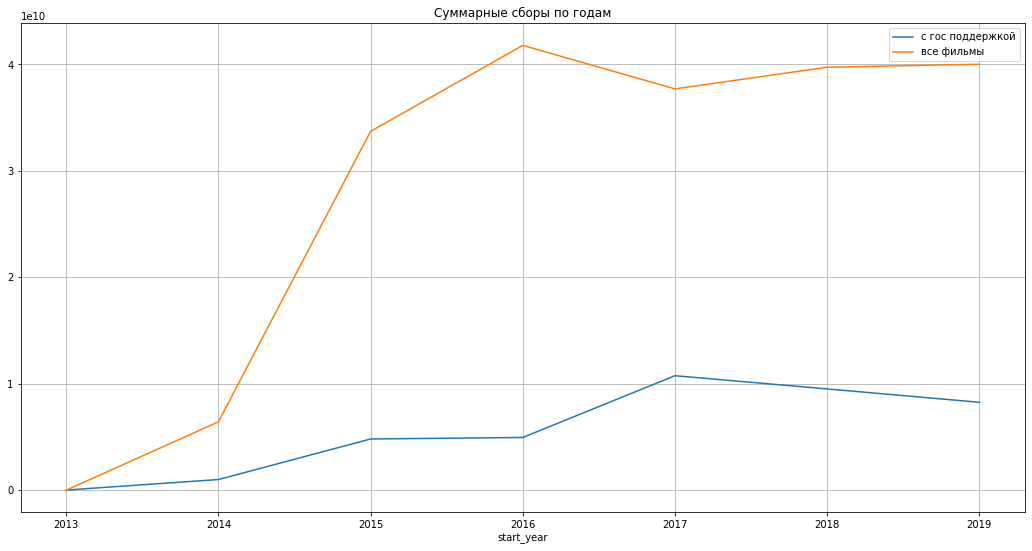

In [80]:
data_gov_box = data_gov.pivot_table(values='box_office', index='start_year', aggfunc='sum')
data_box = data[( data['start_year'] >= 2013 )  &
                      (data['budget_gov'].isnull())].pivot_table(values='box_office',
                                                                          index='start_year',
                                                                          aggfunc='sum')
pivot_data = pd.concat([ data_gov_box, data_box], axis=1)
pivot_data.columns = ['с гос поддержкой', 'все фильмы']
pivot_data.plot(grid=True, figsize=(18, 9))
plt.title('Суммарные сборы по годам')
plt.show()

Вывод: суммарные сборы фильмов без финансирования примерно в 5 раз выше сборов фильмов с гос поддержкой

Посмотрим детализацию по возрастным категориям. Посмотрим количество фильмов и объем поддержки для каждой из них

<AxesSubplot:title={'center':'Количество фильмов c гос поддержкой по категориям'}, xlabel='start_year'>

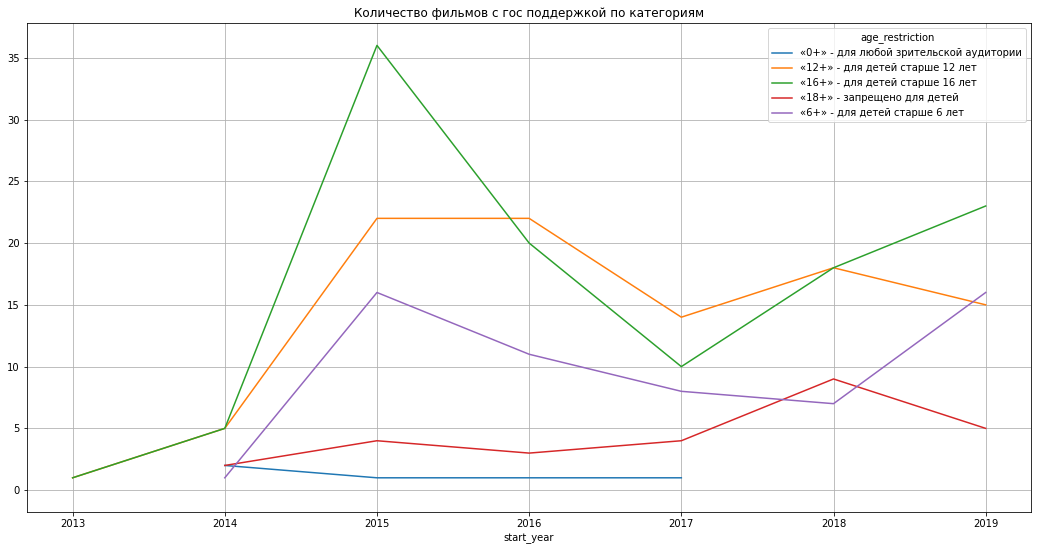

In [81]:
data_gov_age = data_gov.pivot_table(values='box_office', index='start_year', columns=['age_restriction'], aggfunc='count')
data_gov_age.plot(grid=True, figsize=(18, 9), title='Количество фильмов c гос поддержкой по категориям')

Суммарное кол-во по всему периоду

In [82]:
data_gov_age = data_gov.pivot_table(values='box_office',
                                    index='age_restriction',
                                    aggfunc='count').sort_values(by='box_office', ascending=False)
data_gov_age

,box_office
age_restriction,
«16+» - для детей старше 16 лет,113
«12+» - для детей старше 12 лет,97
«6+» - для детей старше 6 лет,59
«18+» - запрещено для детей,27
«0+» - для любой зрительской аудитории,5


In [83]:
data_gov['gos_budget'] = data_gov['refundable_support'] + data_gov['nonrefundable_support']

<AxesSubplot:title={'center':'Объем финансирования фильмов с гос поддержкой по категориям'}, xlabel='start_year'>

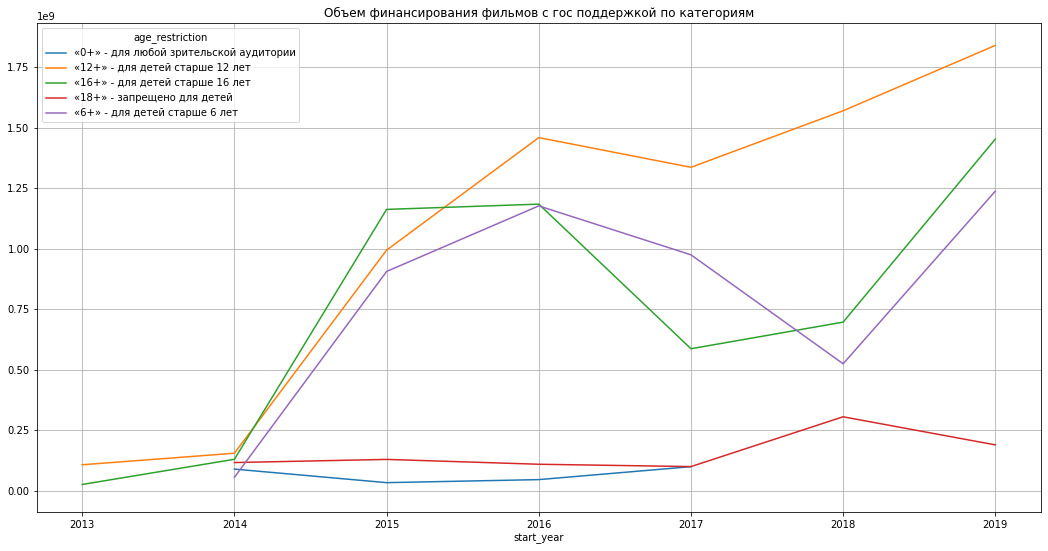

In [84]:
data_gov_age = data_gov.pivot_table(values='gos_budget', index='start_year', columns=['age_restriction'], aggfunc='sum')
data_gov_age.plot(grid=True, figsize=(18, 9), title='Объем финансирования фильмов с гос поддержкой по категориям')

Суммарное сборы по всему периоду

In [85]:
data_gov_age = data_gov.pivot_table(values='gos_budget',
                                    index='age_restriction',
                                    aggfunc='sum').sort_values(by='gos_budget', ascending=False)
data_gov_age['gos_budget'] = data_gov_age['gos_budget'] / 1000000000
data_gov_age.columns = ['бюджет (млрд руб)']
data_gov_age

,бюджет (млрд руб)
age_restriction,
«12+» - для детей старше 12 лет,7.463394
«16+» - для детей старше 16 лет,5.241053
«6+» - для детей старше 6 лет,4.877404
«18+» - запрещено для детей,0.953347
«0+» - для любой зрительской аудитории,0.273520


Вывод: самые многочисленные категории это "12+" и "16+", наименее представлены "0+". По объему финансирования  это категории "12+", "16+" и "6+", наименее финансируемые категории "18+" и "0+". 

Посмотрим совокупную прибыль всех таких фильмов по годам

<AxesSubplot:title={'center':'Совокупная прибыль по годам'}, xlabel='start_year'>

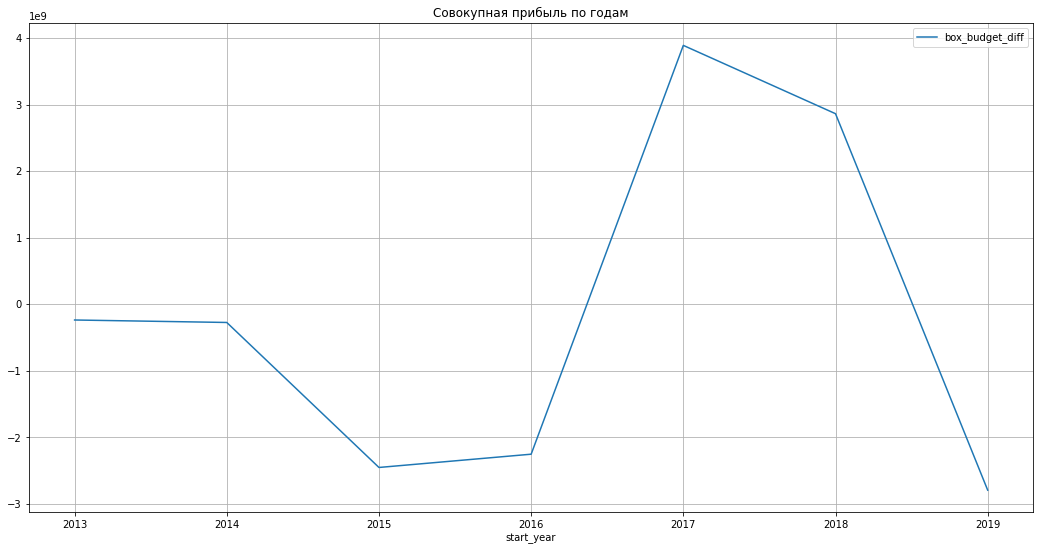

In [86]:
data_gov['box_budget_diff'] = data_gov['box_office'] - data_gov['budget']
data_gov_profit = data_gov.pivot_table(values='box_budget_diff', index='start_year', aggfunc='sum')
data_gov_profit.plot(grid=True, figsize=(18, 9), title='Совокупная прибыль по годам')

In [87]:
data_gov['box_budget_diff'].sum()

-1245992588.4500003

Вывод: только в 2017 и 2018 году фильмы c гос поддержкой показали показали положительную прибыль. Суммарно же на всем рассматриваемом периоде(с 2013 по 2019) эти фильмы показали суммарный убыток в 1.2 млр руб.

Вывод по исследованию: С годами государственное финансирование фильмов растет. Не смотря на их общую неокупаемость, в 2017 и 2018 годах они показали хорошую прибыль. Средний рейтинг этих фильмов ниже общего-среднего по всем фильмам

## Общий вывод:

Мы ознакомились с рынком российского кинопроката за несколько последних лет. В датасете присутствовало большое количество пропусков в столбце прокатных сборов, поэтому исследование не может считаться законченным. Также, имелось небольшое кол-во нулевых значений, которые пришлось удалить. Наиболее полная информация имелась только с 2015 года. По этому периоду можно сказать следующее: общие годовые сборы фильмов практически не менялись, их количество плавно растет, за исключением 2017 года, где произошел спад. Наибольшую кассу собрала категория "16+", наименьшую "0+". Также мы рассмотрели фильмы, которые получили государственную поддержку. Такие фильмы состовляют около 12% от всего количества. До 2016 года они показывали средние сборы на уровне соответствующих значений среди фильмов без финансирования. Начиная с 2016 сборы пошли заметно вверх и до 2019 года держутся выше средних значений. Суммарные сборы таких фильмов составляют примерно 20% от фильмов без гос поддержки. В основном это фильмы категории "16+" и "12+". Наибольшие расходы гос финансирования идут на категории "12+", "16+" и "6+". Несмотря на их общую неокупаемость и невысокий рейтинг, в 2017 и 2018 году такие фильмы показали прибыль, а эти два года стали самыми успешными для российского кинопроката.

Рекомендации:
* исправить недостающие данные и пропуски в столбце прокатных сборов
* разобраться в причине возникновения нулевых значений в переменной бюджета